In [1]:
using DrWatson, Revise;
@quickactivate "haram";

In [2]:
using main
using DynamicPPL, Bijectors
using Zygote
using LinearAlgebra, Plots, Pipe
using CSV, DataFrames, ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

false

In [3]:
Dists = (;
    Δ=Uniform(-1178.939, 1179.939),
    β=Uniform(-60, 60),
    μ=Uniform(-39, 30),
    σ2=InverseGamma(1.0, 2e-7),
    τ=InverseGamma(1.0, 1.0)
);
K = keys(Dists)
B = map(x -> bijector(x), Dists)
Binv = map(x -> inverse(x), B)

v2n(V::Vector{T}, S::NTuple) where {T<:Real} = NamedTuple{S}(V)
df = CSV.File(datadir("q0957usno.csv")) |> DataFrame;
first(df, 5)

Row,time,lca,sea,lcb,seb
,Float64,Float64,Float64,Float64,Float64
1,4554.71,2.671,0.004,2.419,0.004
2,4555.77,2.659,0.004,2.412,0.004
3,4561.72,2.665,0.004,2.417,0.004
4,4570.67,2.669,0.004,2.413,0.004
5,4584.68,2.664,0.004,2.378,0.004


In [137]:
@model function π_prior(Dists)
    Δ ~ Dists.Δ |> transformed
    β ~ Dists.β |> transformed
    μ ~ Dists.μ |> transformed
    σ2 ~ Dists.σ2 |> transformed
    τ ~ Dists.τ |> transformed
end

function log_likelihood(Binv, θ::Vector{T}, df) where {T<:Real}
    Δ  =  θ[1] |> Binv[1]
    β  =  θ[2] |> Binv[2]
    μ  =  θ[3] |> Binv[3]
    σ2 =  θ[4] |> Binv[4]
    τ  =  θ[5] |> Binv[5]

    n, m = size(df)
    var0 = τ * σ2 / 2

    T2n = [df.time; df.time .- Δ]
    ord = sortperm(T2n)

    tΔ = T2n[ord]
    ind = [fill(0, n); fill(1, n)][ord]
    lc = [df.lca; df.lcb .- β][ord]
    se = [df.sea; df.seb][ord]

    x = lc .- μ

    a = [0; exp.(-1 .* (tΔ[2:end] .- tΔ[1:end-1]) ./ τ)]
    B = fill(T(+1), 2n)
    m = fill(T(-1), 2n)
    
    B[1] = se[1]^2 / (se[1]^2 +  var0)
    m[1] = (1 - B[1]) * x[1]

    for i in 2:length(T2n)
        B[i] = se[i]^2 / (
            se[i]^2 + 
            a[i-1]^2 * (1- B[i-1]) * se[i-1]^2 +
            var0 * (1 - a[i-1]^2)
        )
        m[i] = (1 - B[i]) * x[i] + B[i] * a[i-1] * m[i-1]
    end

    D = MvNormal(a .* m, se ./ B)
    return logpdf(D, x)
end

function make_model(Dists, log_likelihood)
    K = keys(Dists)
    B = map(x -> bijector(x), Dists)
    Binv = map(x -> inverse(x), B)

    U(x) = logprior(π_prior(Dists), v2n(x, K)) + log_likelihood(Binv, x, df)
    dU(x) = Zygote.gradient(x_ -> Zygote.forwarddiff(U, x_), x)[1]
    f(x) = max(exp(-U(x)), floatmin(Float64))
    g(x) = Zygote.gradient(x_ -> Zygote.forwarddiff(f, x_), x)
    return main.Model(ξ=Dists, d=length(Dists), f=f, g=g, U=U, dU=dU)
end

make_model (generic function with 1 method)

In [150]:
logprior(π_prior(Dists), v2n(map((f, x) -> f(x), Binv, fill(10, 5)), K))

5-element Vector{Float64}:
  1179.8319119662713
    59.99455225575571
    29.996867547059537
 22026.465794806718
 22026.465794806718

In [127]:
model = make_model(Dists, log_likelihood);

In [128]:
using Setfield
function DualA(D::DualAverage, S::AbstractSampler, M::main.Model; n_burn::Integer=100, p=nothing, ϵ0::T=1.0) where {T <: Real}

    @unpack λ, δ = D

    q = randn(M.d)
    state = InitializeState(q, S, M)
    # println("state = $state")
    ϵ = main.find_reasonable_epsilon(q, M, α=0.5)
    println("epsilon = $ϵ")
    @set! S.ϵ = ϵ

    if typeof(S) === HaRAM
        S_init, _ = DualAveraging(D, HMC(ϵ=ϵ), M; n_burn=n_burn, p=nothing)
        @set! S.ϵ = S_init.ϵ
    end

    S = main.Initialize_DualVariables(S)
    # println("S=$S")

    @showprogress for m in 1:n_burn
        @set! S.L = max(1, round(Int, λ / S.ϵ))
        println("S=$S")
        newstate, α_MH = main.OneStep(state, S, M)
        println("newstate=$newstate")
        α_MH = min(1, α_MH)
        if rand() < α_MH
            state = (; newstate...)
        end
        S = main.Update_DualVariables(S, α_MH, δ, m, 0.75)
        if !isnothing(p)
            next!(p, showvalues=() -> [("$(typeof(S))", "Warming Up...")])
        end
    end

    S = main.Set_DualVariables(S, λ)

    return (S, state)
end

DualA (generic function with 1 method)

In [135]:
using Random; Random.seed!(2022)
state = (; p=randn(5), q=randn(5), m=1.0)
OneStep(state, main.HMC(ϵ=0.0008, L=1), model)
model.U(state.q)

NaN

In [89]:
S, q0 = DualA(
    DualAverage(λ=1, δ=0.5),
    main.HMC(),
    model,
    ϵ0=0.5,
    n_burn=1000
)

epsilon = 0.00087890625
S=HMC(0.00087890625, 1138, (h = 0.0, ϵ_dual = 1.0, ϵ_level = -4.734247228263234, ϵ_rate = 0.75, t0 = 10))
newstate=(q = [NaN, NaN, NaN, NaN, NaN], p = [NaN, NaN, NaN, NaN, NaN], m = 1.0)


LoadError: InexactError: trunc(Int64, NaN)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:00
  HMC:  0.000999857163262391


Acceptance Ratio = 0.001


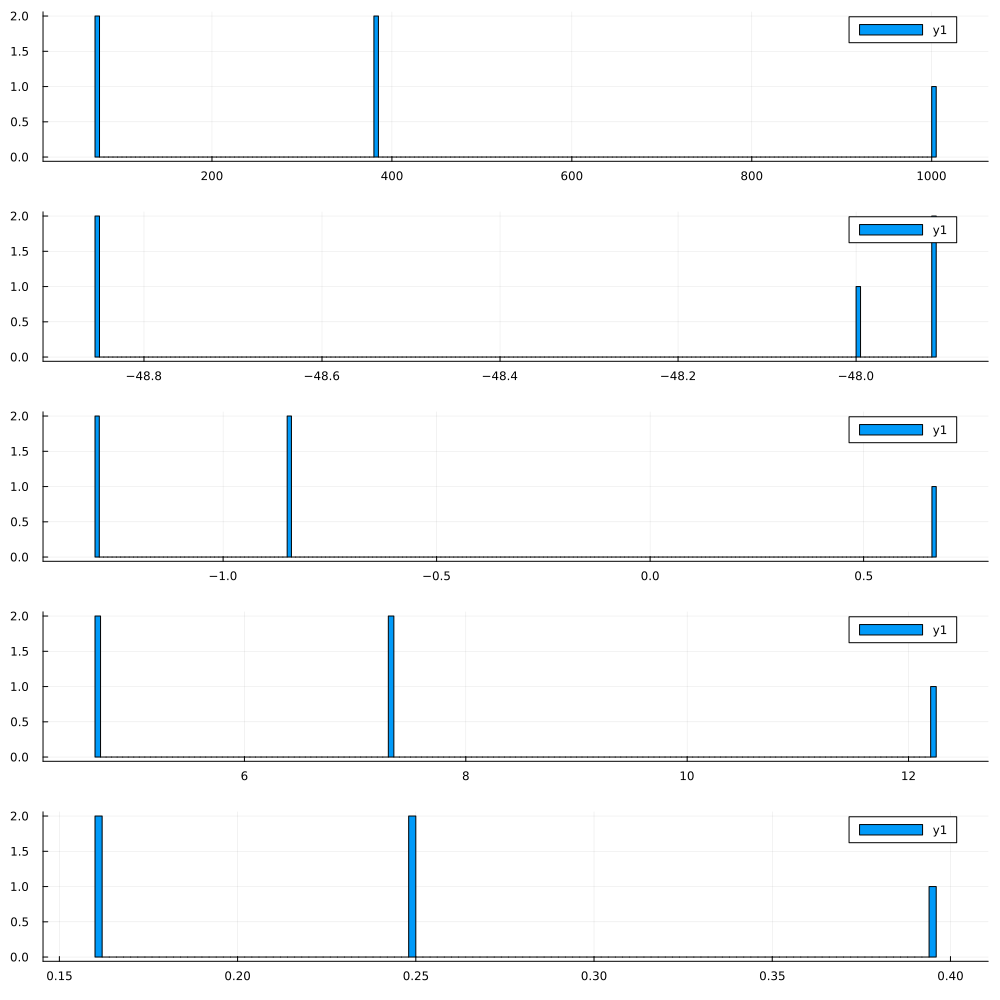

In [58]:
s,a = mcmc(
    PT(τ = [1.0, 2.5, 5.0, 7.5, 10.0]),
    # DualAverage(λ=0.001, δ=0.2), main.HMC(),
    main.HMC(ϵ=0.02, L=5),
    # main.HaRAM(ϵ=0.0005, L=20, γ=0.85),
    # main.HaRAM(ϵ=0.0005, L=20, γ=0.85),
    model; n=5000, n_burn=2000,
)

params = map((f, x) -> f(x), Binv, eachcol(s[a,:]))
plot(
    [histogram(p, bins=200) for p in params]..., 
    layout=(length(params),1), 
    size=(5, length(params)) .* 200
)